# Co-expression analyses

Building from the example here https://docs.pymc.io/notebooks/LKJ.html and here https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb. And http://www.statsmodels.org/0.6.1/_modules/statsmodels/stats/moment_helpers.html

In [3]:
#import sys 
#print('\n'.join(sys.path))
#print(sys.path)

In [4]:
#sys.path.append("C:\Users\Alexander\Miniconda3\pkgs")

In [5]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import toyplot
from statsmodels.stats.moment_helpers import corr2cov, cov2corr

ModuleNotFoundError: No module named 'numpy'

### Define the shape of your simulated data

Each row represent a variable (gene) and columns are the observations.

In [40]:
# dimensions of the data
ncells = 500
ngenes = 10

### Covariance
We want to simulate data that has a correlation structure to it, but a correlation matrix itself does not provide sufficient information to do this, since data can be distributed in a number of ways and still have the same correlation for two values. Instead we need to generate a variance covariance matrix, which combines a correlation matrix and the standard deviation of those correlations. Formula for conversion of correlation matrix to VCV was found here [http://www.statsmodels.org/0.6.1/_modules/statsmodels/stats/moment_helpers.html](http://www.statsmodels.org/0.6.1/_modules/statsmodels/stats/moment_helpers.html). 

To simulate data to test the model I generate a correlation matrix, and sample means and standard deviations for each gene. From the correlation matrix and stdevs I generate a variance-covariance matrix. With sample means and a variance-covariance matrix we can now generate data that has a covariance structure by using the `np.random.multivariate_normal()` sampler. 

In [3]:
# fix random seed
np.random.seed(333)

# mean expression of each gene (normalized read counts) from uniform distribution  
mu = np.random.uniform(5, 10, ngenes)

# standard deviation of expression
estds = np.random.uniform(0, 2, ngenes)

# correlation matrix: use broadcasting to fill a symmetric matrix 
# with random uniform values in (-.99, .99) and set the diag to 1.
cor = np.random.uniform(-0.99, 0.99, ngenes)
cor = cor[:, None] * cor
np.fill_diagonal(cor, 1)
pd.DataFrame(cor).round(2)

# variance-covariance matrix from stds
print('variance-covariance matrix')
vcv = np.array(np.diag(estds) * np.matrix(cor) * np.diag(estds))
pd.DataFrame(vcv).round(2)

variance-covariance matrix


,0,1,2,3,4,5,6,7,8,9
0,0.01,-0.00,-0.02,-0.01,-0.01,-0.02,-0.07,0.04,-0.05,0.07
1,-0.00,0.01,0.00,0.00,0.00,0.00,0.01,-0.00,0.00,-0.01
2,-0.02,0.00,0.23,0.11,0.11,0.15,0.56,-0.32,0.40,-0.53
3,-0.01,0.00,0.11,0.17,0.10,0.13,0.51,-0.29,0.36,-0.48
4,-0.01,0.00,0.11,0.10,0.12,0.13,0.51,-0.29,0.36,-0.48
5,-0.02,0.00,0.15,0.13,0.13,0.69,0.67,-0.39,0.48,-0.64
6,-0.07,0.01,0.56,0.51,0.51,0.67,3.55,-1.46,1.81,-2.42
7,0.04,-0.00,-0.32,-0.29,-0.29,-0.39,-1.46,0.87,-1.04,1.39
8,-0.05,0.00,0.40,0.36,0.36,0.48,1.81,-1.04,3.69,-1.72
9,0.07,-0.01,-0.53,-0.48,-0.48,-0.64,-2.42,1.39,-1.72,4.00


In [4]:
# plot the correlation and covariance matrices
canvas = toyplot.Canvas(width=900, height=300)

canvas.matrix(
    cor,
    tlabel="correlation", 
    bounds=(25, 275, 25, 275));

canvas.matrix(
    vcv,
     tlabel="covariance", 
     bounds=(300, 550, 25, 275));

axes = canvas.cartesian(
    bounds=(600, 800, 55, 235), 
    ylabel="genes",
    xlabel="standard deviation")
axes.bars(estds[::-1], along='y', color=toyplot.color.brewer.map("BlueRed", reverse=True));

0 1 2 3 4 5 6 7 8 9 0 1.0 -0.0139931679441 -0.331068953883 -0.350106124746 -0.40612625547 -0.227020735559 -0.380173106606 0.439694237068 -0.264999489561 0.339331276733 1 -0.0139931679441 1.0 0.0230711465801 0.0243977867084 0.0283016521487 0.0158203558666 0.0264930594231 -0.0306408984439 0.0184669749175 -0.0236469216848 2 -0.331068953883 0.0230711465801 1.0 0.577235244718 0.669598078678 0.374298992746 0.626807989682 -0.724943074673 0.436916221669 -0.55947028264 3 -0.350106124746 0.0243977867084 0.577235244718 1.0 0.70810139614 0.395821983033 0.662850785776 -0.766628847431 0.462039836152 -0.591641016979 4 -0.40612625547 0.0283016521487 0.669598078678 0.70810139614 1.0 0.459157062501 0.768912876798 -0.889296362264 0.535970368045 -0.686308904144 5 -0.227020735559 0.0158203558666 0.374298992746 0.395821983033 0.459157062501 1.0 0.429815025549 -0.497108255306 0.299602366388 -0.383640186126 6 -0.380173106606 0.0264930594231 0.626807989682 0.662850785776 0.768912876798 0.429815025549 1.0 -0.832466643516 0.501719642903 -0.642450924227 7 0.439694237068 -0.0306408984439 -0.724943074673 -0.766628847431 -0.889296362264 -0.497108255306 -0.832466643516 1.0 -0.580270491981 0.743035117617 8 -0.264999489561 0.0184669749175 0.436916221669 0.462039836152 0.535970368045 0.299602366388 0.501719642903 -0.580270491981 1.0 -0.447820122018 9 0.339331276733 -0.0236469216848 -0.55947028264 -0.591641016979 -0.686308904144 -0.383640186126 -0.642450924227 0.743035117617 -0.447820122018 1.0 correlation 0 1 2 3 4 5 6 7 8 9 0 0.0106550452461 -0.00017472098336 -0.0163174202017 -0.014723011932 -0.0146334864567 -0.0194664826628 -0.073912720212 0.0423834695734 -0.0525187106357 0.0700407274623 1 -0.00017472098336 0.0146319678883 0.00133252676189 0.00120232286553 0.00119501196159 0.00158968812394 0.00603592213163 -0.00346115420024 0.00428882669913 -0.0057197242341 2 -0.0163174202017 0.00133252676189 0.22798736737 0.112286498379 0.111603723538 0.148463044387 0.563702629371 -0.323241698747 0.400539111422 -0.534172495888 3 -0.014723011932 0.00120232286553 0.112286498379 0.165973446782 0.100698697036 0.133956418782 0.508622100536 -0.291657095837 0.361401621323 -0.481977416374 4 -0.0146334864567 0.00119501196159 0.111603723538 0.100698697036 0.121847939043 0.133141876749 0.50552934781 -0.28988363126 0.359204064731 -0.479046680633 5 -0.0194664826628 0.00158968812394 0.148463044387 0.133956418782 0.133141876749 0.690062811721 0.67249034014 -0.385623391859 0.477838259475 -0.637261252185 6 -0.073912720212 0.00603592213163 0.563702629371 0.508622100536 0.50552934781 0.67249034014 3.54748273276 -1.46418201806 1.81431469624 -2.41963139673 7 0.0423834695734 -0.00346115420024 -0.323241698747 -0.291657095837 -0.28988363126 -0.385623391859 -1.46418201806 0.872039518367 -1.04037507352 1.38747935927 8 -0.0525187106357 0.00428882669913 0.400539111422 0.361401621323 0.359204064731 0.477838259475 1.81431469624 -1.04037507352 3.68623261777 -1.71926998229 9 0.0700407274623 -0.0057197242341 -0.534172495888 -0.481977416374 -0.479046680633 -0.637261252185 -2.41963139673 1.38747935927 -1.71926998229 3.99851026917 covariance 0.0 0.5 1.0 1.5 2.0 standard deviation 0 5 10 genes

### Simulate data from this VCV

In [5]:
# set seed
np.random.seed(12345)

# sample data from this distribution
data = np.random.multivariate_normal(mu, vcv, size=ncells, check_valid='ignore')

#### Visualize the data matrix

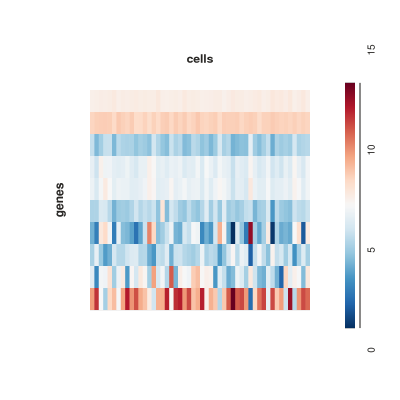

In [6]:
# transposed to look like Alex's data file
canvas, table = toyplot.matrix(
    data[::10].T,
    lshow=False,
    tshow=False,
    width=400, 
    height=400, 
    tlabel="cells",
    llabel="genes", 
    colorshow=True,
);

# png format is less memory intensive
canvas.autorender(autoformat='png')

#### Visualize correlation of gene expression for two genes across cells
Hover over plots to see pop-ups. 

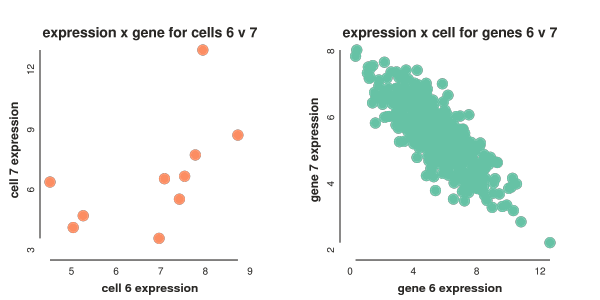

In [7]:
# what does the correlation look for gene expression of cells 0 and 1
canvas = toyplot.Canvas(width=600, height=300)

# which genes to plot
x, y = 6, 7

# create the axes
ax1 = canvas.cartesian(
    bounds=(50, 250, 50, 250), 
    xlabel="cell {} expression".format(x),
    ylabel="cell {} expression".format(y),
    label="expression x gene for cells {} v {}".format(x, y)
    )
ax2 = canvas.cartesian(
    bounds=(350, 550, 50, 250), 
    xlabel="gene {} expression".format(x),
    ylabel="gene {} expression".format(y),
    label="expression x cell for genes {} v {}".format(x, y),
    )

# add scatterplots to axes
ax1.scatterplot(
    data[x, :], data[y, :],
    size=10,
    title=["gene-{}".format(i) for i in range(ngenes)],
    color=toyplot.color.Palette()[1],
    );
ax2.scatterplot(
    data[:, x], data[:, y],
    size=10,
    title=["cell-{}".format(i) for i in range(ncells)],
    );

# png format is less memory intensive
canvas.autorender(autoformat='png')

### Estimate covariance matrix using Pymc3
https://docs.pymc.io/notebooks/LKJ.html. This is done using a prior on the covariance matrix that is defined by sampling standard deviations among samples and converting this to a lower triangle representation of the VCV. This convoluted method makes it quite fast. 

In [8]:
x = data
xsize = x.shape[1]
xmeans = x.mean(axis=0)

In [9]:
with pm.Model() as model:
    
    # distribution to draw stds from (not a rv for now) but is a wide prior
    stds = pm.HalfCauchy.dist(2)
    
    # sample correlations by drawing halfCauchy std values
    # eta=1 is uniform corrs, eta>1 puts more weight on corr=0.
    packed = pm.LKJCholeskyCov('packed_chol', n=xsize, eta=1., sd_dist=stds)
    
    # expand correlation matrix and define VCV as dot product
    chol = pm.expand_packed_triangular(xsize, packed)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    sigma = pm.Deterministic('sigma', tt.sqrt(tt.diag(cov)))

    # draw the means from a normal with starting values from observed means
    # set this mean and std of this dist according to your data, or it could
    # be made into a random variable to be fit.
    means = pm.Normal('means', 5, 5, shape=xsize, testval=xmeans)
    obs = pm.MvNormal('obs', means, chol=chol, observed=x)

In [10]:
with model:
    trace = pm.sample(tune=1000, draws=5000, njobs=3, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [04:16<00:00, 23.35it/s]


### Examine traceplot
This looks like a really good match to the simulated data. Means were drawn uniformly from 20-100 and stds were drawn uniformly from 0-10. Correlations were drawn uniformly between -0.9 and 0.9, though these seem slighly underestimated. I think it may help to standardize the data before analysis, for example scaling expression to be in the range -1 to 1. 

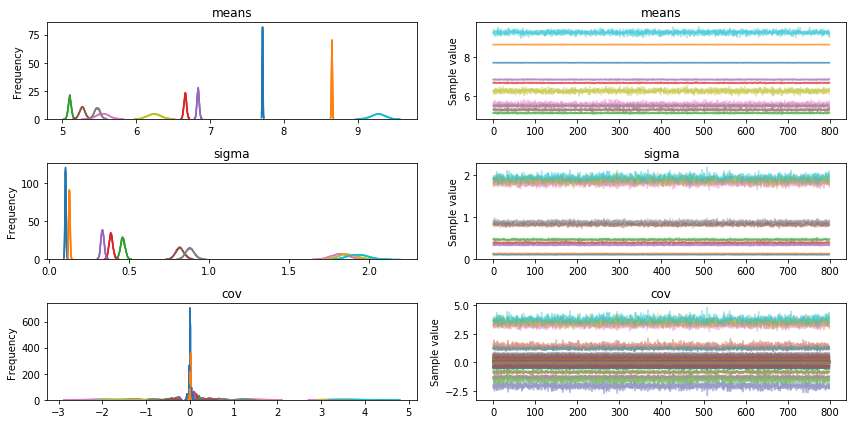

In [11]:
# plot the trace 
pm.traceplot(trace[1000::5], varnames=["means", "sigma", "cov"]);

In [12]:
### Look at posterior parameter estimates
#pm.summary(trace[1000::2], varnames=['cov'])

### Show posterior means

In [13]:
evcv = np.mean(trace[1000::5]["cov"], axis=0)
mvcv = np.median(trace[1000::5]["cov"], axis=0)
pd.DataFrame(mvcv).round(2)

,0,1,2,3,4,5,6,7,8,9
0,0.01,0.00,-0.01,-0.01,-0.01,-0.02,-0.07,0.03,-0.04,0.06
1,0.00,0.02,-0.00,0.00,-0.00,-0.01,-0.01,0.01,-0.01,0.00
2,-0.01,-0.00,0.21,0.10,0.10,0.13,0.49,-0.28,0.31,-0.47
3,-0.01,0.00,0.10,0.15,0.09,0.12,0.43,-0.25,0.28,-0.40
4,-0.01,-0.00,0.10,0.09,0.11,0.12,0.45,-0.26,0.28,-0.42
5,-0.02,-0.01,0.13,0.12,0.12,0.67,0.52,-0.33,0.34,-0.43
6,-0.07,-0.01,0.49,0.43,0.45,0.52,3.30,-1.27,1.43,-2.04
7,0.03,0.01,-0.28,-0.25,-0.26,-0.33,-1.27,0.77,-0.84,1.23
8,-0.04,-0.01,0.31,0.28,0.28,0.34,1.43,-0.84,3.46,-1.48
9,0.06,0.00,-0.47,-0.40,-0.42,-0.43,-2.04,1.23,-1.48,3.71


In [14]:
# plot matrices on the same scale and colorbar
cm = toyplot.color.brewer.map("BlueRed", domain_min=vcv.min(), domain_max=vcv.max())
canvas = toyplot.Canvas(width=900, height=300)
canvas.matrix((vcv, cm), tlabel="true vcv", bounds=(25, 275, 25, 275));
canvas.matrix((mvcv, cm), tlabel="estimated vcv", bounds=(300, 550, 25, 275));
canvas.matrix((vcv-mvcv, cm), step=5, tlabel="error", bounds=(575, 825, 25, 275));

0 1 2 3 4 5 6 7 8 9 0 0.0106550452461 -0.00017472098336 -0.0163174202017 -0.014723011932 -0.0146334864567 -0.0194664826628 -0.073912720212 0.0423834695734 -0.0525187106357 0.0700407274623 1 -0.00017472098336 0.0146319678883 0.00133252676189 0.00120232286553 0.00119501196159 0.00158968812394 0.00603592213163 -0.00346115420024 0.00428882669913 -0.0057197242341 2 -0.0163174202017 0.00133252676189 0.22798736737 0.112286498379 0.111603723538 0.148463044387 0.563702629371 -0.323241698747 0.400539111422 -0.534172495888 3 -0.014723011932 0.00120232286553 0.112286498379 0.165973446782 0.100698697036 0.133956418782 0.508622100536 -0.291657095837 0.361401621323 -0.481977416374 4 -0.0146334864567 0.00119501196159 0.111603723538 0.100698697036 0.121847939043 0.133141876749 0.50552934781 -0.28988363126 0.359204064731 -0.479046680633 5 -0.0194664826628 0.00158968812394 0.148463044387 0.133956418782 0.133141876749 0.690062811721 0.67249034014 -0.385623391859 0.477838259475 -0.637261252185 6 -0.073912720212 0.00603592213163 0.563702629371 0.508622100536 0.50552934781 0.67249034014 3.54748273276 -1.46418201806 1.81431469624 -2.41963139673 7 0.0423834695734 -0.00346115420024 -0.323241698747 -0.291657095837 -0.28988363126 -0.385623391859 -1.46418201806 0.872039518367 -1.04037507352 1.38747935927 8 -0.0525187106357 0.00428882669913 0.400539111422 0.361401621323 0.359204064731 0.477838259475 1.81431469624 -1.04037507352 3.68623261777 -1.71926998229 9 0.0700407274623 -0.0057197242341 -0.534172495888 -0.481977416374 -0.479046680633 -0.637261252185 -2.41963139673 1.38747935927 -1.71926998229 3.99851026917 true vcv 0 1 2 3 4 5 6 7 8 9 0 0.0104347738099 0.000460251615727 -0.0126932910062 -0.0109351975374 -0.0107506100124 -0.0156089442666 -0.0652334340925 0.0343040526666 -0.0400442756893 0.0597619382462 1 0.000460251615727 0.0158368928905 -0.000732002904602 0.000398806065455 -0.00244421662705 -0.00591200222142 -0.00971634537197 0.00572276592875 -0.0124247104077 0.00174918654483 2 -0.0126932910062 -0.000732002904602 0.211120012381 0.100092490894 0.10170630672 0.126396803278 0.488868551699 -0.282781821645 0.314810536049 -0.469948457826 3 -0.0109351975374 0.000398806065455 0.100092490894 0.14857962788 0.0861940221882 0.115251056684 0.432520468595 -0.2462373525 0.279479691828 -0.404663355349 4 -0.0107506100124 -0.00244421662705 0.10170630672 0.0861940221882 0.110696612398 0.115724664125 0.447335953075 -0.259404058993 0.282496018713 -0.422651475343 5 -0.0156089442666 -0.00591200222142 0.126396803278 0.115251056684 0.115724664125 0.665684699537 0.51530447379 -0.33072085029 0.342790060044 -0.430649726723 6 -0.0652334340925 -0.00971634537197 0.488868551699 0.432520468595 0.447335953075 0.51530447379 3.30234823105 -1.27239400865 1.42662954984 -2.04297381194 7 0.0343040526666 0.00572276592875 -0.282781821645 -0.2462373525 -0.259404058993 -0.33072085029 -1.27239400865 0.773203868803 -0.83713632378 1.23212859336 8 -0.0400442756893 -0.0124247104077 0.314810536049 0.279479691828 0.282496018713 0.342790060044 1.42662954984 -0.83713632378 3.4642863106 -1.48444201345 9 0.0597619382462 0.00174918654483 -0.469948457826 -0.404663355349 -0.422651475343 -0.430649726723 -2.04297381194 1.23212859336 -1.48444201345 3.71497191263 estimated vcv 0 5 0 0.00022027143619 -0.000634972599087 -0.00362412919544 -0.00378781439457 -0.00388287644426 -0.00385753839621 -0.00867928611956 0.00807941690682 -0.0124744349465 0.0102787892161 -0.000634972599087 -0.00120492500226 0.00206452966649 0.000803516800074 0.00363922858863 0.00750169034536 0.0157522675036 -0.00918392012899 0.0167135371069 -0.00746891077893 -0.00362412919544 0.00206452966649 0.0168673549885 0.0121940074857 0.00989741681823 0.022066241109 0.0748340776717 -0.0404598771027 0.0857285753732 -0.0642240380622 -0.00378781439457 0.000803516800074 0.0121940074857 0.0173938189025 0.0145046748481 0.0187053620973 0.0761016319416 -0.0454197433365 0.0819219294947 -0.0773140610249 -0.00388287644426 0.00363922858863 0.00989741681823 0.014504674

### Did the chains converge?

In [15]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

1.0003129481751118

### Posterior has estimates of mean expression and correlation

In [16]:
# true stdevs
estds

array([ 0.10322328,  0.12096267,  0.47748023,  0.40739839,  0.34906724,
        0.83070019,  1.88347624,  0.93383056,  1.91995641,  1.99962753])

In [17]:
# estimated stdevs
trace["sigma"].mean(axis=0)

array([ 0.10230326,  0.12602472,  0.46029008,  0.38576634,  0.333012  ,
        0.81716852,  1.81678609,  0.87950232,  1.8631548 ,  1.92922023])

In [18]:
toyplot.scatterplot(
    estds, trace["sigma"].mean(axis=0), 
    width=300, 
    height=300, 
    size=10,
    xlabel="true stdev of genen expression",
    ylabel="estimated stdevs of gene expression",
);

0.0 0.5 1.0 1.5 2.0 true stdev of genen expression 0.0 0.5 1.0 1.5 2.0 estimated stdevs of gene expression

### Convert vcv to corr

In [19]:
C = cov2corr(mvcv)
pd.DataFrame(C).round(2)

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.04,-0.27,-0.28,-0.32,-0.19,-0.35,0.38,-0.21,0.30
1,0.04,1.00,-0.01,0.01,-0.06,-0.06,-0.04,0.05,-0.05,0.01
2,-0.27,-0.01,1.00,0.57,0.67,0.34,0.59,-0.70,0.37,-0.53
3,-0.28,0.01,0.57,1.00,0.67,0.37,0.62,-0.73,0.39,-0.54
4,-0.32,-0.06,0.67,0.67,1.00,0.43,0.74,-0.89,0.46,-0.66
5,-0.19,-0.06,0.34,0.37,0.43,1.00,0.35,-0.46,0.23,-0.27
6,-0.35,-0.04,0.59,0.62,0.74,0.35,1.00,-0.80,0.42,-0.58
7,0.38,0.05,-0.70,-0.73,-0.89,-0.46,-0.80,1.00,-0.51,0.73
8,-0.21,-0.05,0.37,0.39,0.46,0.23,0.42,-0.51,1.00,-0.41
9,0.30,0.01,-0.53,-0.54,-0.66,-0.27,-0.58,0.73,-0.41,1.00


In [20]:
# true correlation
pd.DataFrame(cor).round(2)

,0,1,2,3,4,5,6,7,8,9
0,1.00,-0.01,-0.33,-0.35,-0.41,-0.23,-0.38,0.44,-0.26,0.34
1,-0.01,1.00,0.02,0.02,0.03,0.02,0.03,-0.03,0.02,-0.02
2,-0.33,0.02,1.00,0.58,0.67,0.37,0.63,-0.72,0.44,-0.56
3,-0.35,0.02,0.58,1.00,0.71,0.40,0.66,-0.77,0.46,-0.59
4,-0.41,0.03,0.67,0.71,1.00,0.46,0.77,-0.89,0.54,-0.69
5,-0.23,0.02,0.37,0.40,0.46,1.00,0.43,-0.50,0.30,-0.38
6,-0.38,0.03,0.63,0.66,0.77,0.43,1.00,-0.83,0.50,-0.64
7,0.44,-0.03,-0.72,-0.77,-0.89,-0.50,-0.83,1.00,-0.58,0.74
8,-0.26,0.02,0.44,0.46,0.54,0.30,0.50,-0.58,1.00,-0.45
9,0.34,-0.02,-0.56,-0.59,-0.69,-0.38,-0.64,0.74,-0.45,1.00


In [23]:
canvas, table = toyplot.matrix(C, tlabel="co-expression", width=400, height=400);

0 1 2 3 4 5 6 7 8 9 0 1.0 0.0358029500245 -0.270438186949 -0.277718927739 -0.316318376322 -0.18728272624 -0.351412566879 0.38190636935 -0.210616326694 0.303532631715 1 0.0358029500245 1.0 -0.0126593997306 0.00822142561909 -0.0583764309184 -0.05757915821 -0.0424870443575 0.051715887724 -0.0530449930094 0.00721146285627 2 -0.270438186949 -0.0126593997306 1.0 0.565141451481 0.665297692823 0.337160820023 0.585485259432 -0.69990609787 0.368110045021 -0.530649500949 3 -0.277718927739 0.00822142561909 0.565141451481 1.0 0.672094511451 0.366463727953 0.617469624425 -0.72648606893 0.389550470928 -0.544673790636 4 -0.316318376322 -0.0583764309184 0.665297692823 0.672094511451 1.0 0.426308975333 0.739869637838 -0.886671180678 0.456182139227 -0.659078973654 5 -0.18728272624 -0.05757915821 0.337160820023 0.366463727953 0.426308975333 1.0 0.347550719326 -0.460978084723 0.22572883687 -0.273849606467 6 -0.351412566879 -0.0424870443575 0.585485259432 0.617469624425 0.739869637838 0.347550719326 1.0 -0.796275168272 0.421786711206 -0.583275317275 7 0.38190636935 0.051715887724 -0.69990609787 -0.72648606893 -0.886671180678 -0.460978084723 -0.796275168272 1.0 -0.511496055083 0.726994724947 8 -0.210616326694 -0.0530449930094 0.368110045021 0.389550470928 0.456182139227 0.22572883687 0.421786711206 -0.511496055083 1.0 -0.413788656971 9 0.303532631715 0.00721146285627 -0.530649500949 -0.544673790636 -0.659078973654 -0.273849606467 -0.583275317275 0.726994724947 -0.413788656971 1.0 co-expression

In [24]:
# export final image
import toyplot.svg
toyplot.svg.render(canvas, "cormatrix.svg")